In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os

from time import time

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch
torch.set_default_tensor_type(torch.DoubleTensor)

import gait
import imageio
from scipy import ndimage # submodule dedicated to image processing
#
import utils

In [ ]:
## from scipy.stats import entropy

In [43]:
os.makedirs('./data/mnist', exist_ok=True)

mnist = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data/mnist', train=True, download=False,))
#letters = torch.utils.data.DataLoader(torchvision.datasets.EMNIST('./data/EMNIST', 'letters', train=True, download=True,))
#fashion = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST('./data/fashion', train=True, download=False))

In [52]:
img_size = 28

[Ygrid, Xgrid] = np.meshgrid(np.linspace(0, 1, img_size), np.linspace(0, 1, img_size))
Kmat = np.exp(-np.abs(Xgrid - Ygrid)**2/(0.05**2))
Kmat = torch.tensor(Kmat)

img_kernel = lambda x: torch.matmul(torch.matmul(Kmat, x), Kmat)

#plt.matshow(Kmat)
data = mnist

### Show data samples

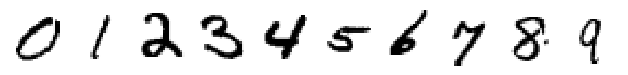

In [53]:
toshow = []
for digit in range(0, 10):
    ix = data.dataset.targets == digit
    D = data.dataset.data[ix].view(-1, 28, 28).float()
    toshow.append(D[np.random.choice(D.shape[0])])
    
plt.figure(figsize=(11, 2))
plt.imshow(torch.cat(toshow, dim=1).data.numpy(), cmap='gray_r')
plt.axis('off')
plt.show()

### Compute barycenters

In [56]:
barys = []

for digit in range(0, 10):
    start = time()
    ix = data.dataset.targets == digit
    D = data.dataset.data[ix].view(-1, 28, 28).float()
    
    # for EMNIST
    #D = data.dataset.train_data[ix].view(-1, 28, 28).transpose(-1, -2).float()
    
    logit_q = torch.nn.Parameter(0*torch.rand(1, img_size*img_size))
    temp = torch.nn.Parameter(torch.tensor(0.1))

    optimizer = torch.optim.Adam([logit_q, temp], lr=0.03, amsgrad=True)
    
    for i in range(500):

        optimizer.zero_grad()
        
        q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(1, img_size, img_size) 
        p = utils.sample_and_resize(D[0:-1, ...], img_size, 32)
        
        loss = gait.breg_sim_divergence_stable(img_kernel, q, p).mean() #this is convex
        
        if i % 100 == 0:
            print("%d - %d : %.3e" % (digit, i, loss.item()))

        if False and i % 100 == 0:
            q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(img_size, img_size).data
            plt.figure(figsize=(1, 1))
            plt.imshow(q, cmap='gray_r');
            plt.show()

        loss.backward()
        optimizer.step()
    
    q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(img_size, img_size)
    barys.append(q.data)
    
    print('Class time: ', time()-start)

0 - 0 : 2.322e-02
0 - 100 : 1.115e-02
0 - 200 : 1.071e-02
0 - 300 : 1.095e-02
0 - 400 : 1.020e-02
Class time:  4.816383361816406
1 - 0 : 5.911e-02
1 - 100 : 2.226e-02
1 - 200 : 2.049e-02
1 - 300 : 2.241e-02
1 - 400 : 2.073e-02
Class time:  4.593292713165283
2 - 0 : 2.544e-02
2 - 100 : 1.389e-02
2 - 200 : 1.569e-02
2 - 300 : 1.341e-02
2 - 400 : 1.364e-02
Class time:  4.788929224014282
3 - 0 : 2.614e-02
3 - 100 : 1.284e-02
3 - 200 : 1.634e-02
3 - 300 : 1.446e-02
3 - 400 : 1.350e-02
Class time:  4.623960733413696
4 - 0 : 3.023e-02
4 - 100 : 1.560e-02
4 - 200 : 1.664e-02
4 - 300 : 1.679e-02
4 - 400 : 1.681e-02
Class time:  4.516130208969116
5 - 0 : 3.079e-02
5 - 100 : 1.846e-02
5 - 200 : 1.676e-02
5 - 300 : 2.016e-02
5 - 400 : 1.571e-02
Class time:  4.527179956436157
6 - 0 : 2.988e-02
6 - 100 : 1.299e-02
6 - 200 : 1.376e-02
6 - 300 : 1.228e-02
6 - 400 : 1.434e-02
Class time:  4.512939214706421
7 - 0 : 3.556e-02
7 - 100 : 1.953e-02
7 - 200 : 1.593e-02
7 - 300 : 1.567e-02
7 - 400 : 1.477e-02

### Show computed barycenters

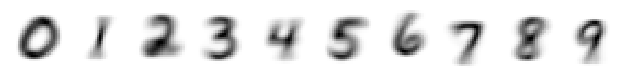

In [57]:
plt.figure(figsize=(1.1*len(barys), 2.5))
cat_barys = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in barys], dim=1)
plt.imshow(cat_barys**1.2, cmap='gray_r')
plt.axis('off')
#plt.savefig('mnist_gray_barys_breg', dpi=300)
plt.show()

--------------------
--------------------
### Show data to Interpolate

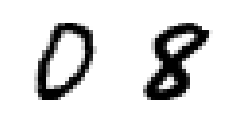

In [4]:
tointerpolate = []
for digit in [0,8]:
    ix = data.dataset.targets == digit
    D = data.dataset.data[ix].view(-1, 28, 28).float()
    tointerpolate.append(D[np.random.choice(D.shape[0])])
    
plt.figure(figsize=(11, 2))
plt.imshow(torch.cat(tointerpolate, dim=1).data.numpy(), cmap='gray_r')
plt.axis('off')
plt.show()

### Compute Interpolation

In [10]:
interp = []
times = np.linspace(0, 1, 11)

for t in times:
    start = time()
    D = tointerpolate
    print(t)
    # for EMNIST
    #D = data.dataset.train_data[ix].view(-1, 28, 28).transpose(-1, -2).float()
    
    logit_q = torch.nn.Parameter(0*torch.rand(1, img_size*img_size))
    temp = torch.nn.Parameter(torch.tensor(0.1))

    optimizer = torch.optim.Adam([logit_q, temp], lr=0.03, amsgrad=True)
    
    for i in range(500):

        optimizer.zero_grad()
        
        q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(1, img_size, img_size)
        res = []
        for ix in range(len(D)):
            sample_img = D[ix].data.numpy()
            sample_img = np.abs(sample_img) / np.abs(sample_img).sum()
            res.append(sample_img)
        p = torch.tensor(res).double()
        
        loss = t*gait.breg_sim_divergence(img_kernel, q, p[0]) + (1-t)*gait.breg_sim_divergence(img_kernel,q , p[1]) #this is convex
        
        if i % 100 == 0:
            print("t=%.1f - %d : %.3e" % (t, i, loss.item()))

        if False and i % 100 == 0:
            q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(img_size, img_size).data
            plt.figure(figsize=(1, 1))
            plt.imshow(q, cmap='gray_r');
            plt.show()

        loss.backward()
        optimizer.step()
    
    q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(img_size, img_size)
    interp.append(q.data)
    
    print('Class time: ', time()-start)

0.0
t=0.0 - 0 : 4.142e+01
t=0.0 - 100 : 1.672e-02
t=0.0 - 200 : 5.853e-03
t=0.0 - 300 : 3.294e-03
t=0.0 - 400 : 2.155e-03
Class time:  1.1144015789031982
0.1
t=0.1 - 0 : 3.899e+01
t=0.1 - 100 : 2.991e-01
t=0.1 - 200 : 2.902e-01
t=0.1 - 300 : 2.880e-01
t=0.1 - 400 : 2.870e-01
Class time:  1.201474905014038
0.2
t=0.2 - 0 : 3.657e+01
t=0.2 - 100 : 4.496e-01
t=0.2 - 200 : 4.420e-01
t=0.2 - 300 : 4.400e-01
t=0.2 - 400 : 4.390e-01
Class time:  1.2361390590667725
0.30000000000000004
t=0.3 - 0 : 3.415e+01
t=0.3 - 100 : 5.416e-01
t=0.3 - 200 : 5.349e-01
t=0.3 - 300 : 5.330e-01
t=0.3 - 400 : 5.320e-01
Class time:  1.1866309642791748
0.4
t=0.4 - 0 : 3.173e+01
t=0.4 - 100 : 6.001e-01
t=0.4 - 200 : 5.939e-01
t=0.4 - 300 : 5.921e-01
t=0.4 - 400 : 5.912e-01
Class time:  1.2296102046966553
0.5
t=0.5 - 0 : 2.931e+01
t=0.5 - 100 : 6.326e-01
t=0.5 - 200 : 6.271e-01
t=0.5 - 300 : 6.255e-01
t=0.5 - 400 : 6.247e-01
Class time:  1.1887266635894775
0.6000000000000001
t=0.6 - 0 : 2.688e+01
t=0.6 - 100 : 6.396e

### Show computed Interpolation

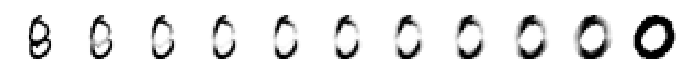

In [11]:
plt.figure(figsize=(1.1*len(interp), 2.5))
cat_interp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in interp], dim=1)
plt.imshow(cat_interp**1.2, cmap='gray_r')
plt.axis('off')
#plt.savefig('mnist_gray_barys_breg', dpi=300)
plt.show()

--------------------
--------------------
##   GAIT One Dimension

In [2]:
sequence_length = 20

Kmat = np.ones([sequence_length,sequence_length])

[Ygrid, Xgrid] = [np.linspace(0, 1, sequence_length), np.linspace(0, 1, sequence_length)]
for i, y in enumerate(Ygrid):
    for j, x in enumerate(Xgrid):
        Kmat[i][j] = np.exp(-np.abs(x-y)**2/(5e-2))
Kmat = torch.tensor(Kmat)
line_kernel = lambda x: torch.matmul(x,Kmat)

### Generate Sequence

In [7]:
length = sequence_length
pattern = [[i%2 for i in np.linspace(0,length-1,length)]]
pattern = np.abs(pattern)/np.abs(pattern).sum(-1)
pattern_tensor = torch.tensor(pattern).double()

In [4]:
length = sequence_length
pattern = [np.concatenate((np.ones(int(sequence_length/2)),np.zeros(int(sequence_length/2))))]
pattern = np.abs(pattern)/np.abs(pattern).sum(-1)
pattern_tensor = torch.tensor(pattern).double()

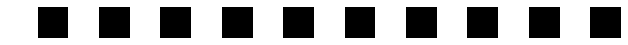

In [8]:
plt.figure(figsize=(11, 2))
#cat_pattern = torch.cat( [ (pattern_tensor - pattern_tensor.min()) / (pattern_tensor.max() - pattern_tensor.min())  ], dim=1)
plt.imshow(pattern_tensor, cmap='gray_r')
plt.axis('off')
plt.show()

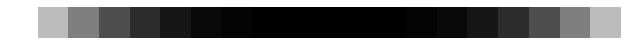

In [9]:
plt.figure(figsize=(11, 2))
#cat_pattern = torch.cat( [ (pattern_tensor - pattern_tensor.min()) / (pattern_tensor.max() - pattern_tensor.min())  ], dim=1)
plt.imshow(line_kernel(pattern_tensor), cmap='gray_r')
plt.axis('off')
plt.show()

### Compute GAIT Entropy

In [218]:
gait_entropy = -1*(pattern_tensor * torch.log(line_kernel(pattern_tensor))).sum(-1)
print("GAIT Entropy= {}".format(gait_entropy))
shannon_entropy = entropy(pattern[0])
print("Shannon Entropy= {}".format(shannon_entropy))

GAIT Entropy= tensor([0.5373])
Shannon Entropy= 6.214608098422188


--------------------
--------------------
##   Interpolate External Images

###  Polynomial Kernel

In [402]:
img_size = 50
degree=10
c=50
p=2

[Ygrid, Xgrid] = np.meshgrid(np.linspace(0, 1, img_size), np.linspace(0, 1, img_size))

In [403]:
unpacked_X = Xgrid.reshape(-1)
unpacked_Y = Ygrid.reshape(-1)
Data = []
for i, y in enumerate(unpacked_Y):
    Data.append([unpacked_X[i],unpacked_Y[i]])
Data = np.array(Data)
Grid = torch.tensor(Data).double()
pdist = utils.batch_pdist(Grid, Grid,p)

In [404]:
Kmat = 1 / (1 + c * pdist)**degree
poly_kernel = lambda x: torch.matmul(x,Kmat)

###  Import 2 External Images

In [405]:
im_initial = imageio.imread("circle-50x50.png")
im_final = imageio.imread("circles-50x50.png")

In [406]:
im_initial = np.abs(im_initial[:,:,0]) / np.abs(im_initial[:,:,0]).sum()
im_final = np.abs(im_final[:,:,0]) / np.abs(im_final[:,:,0]).sum()

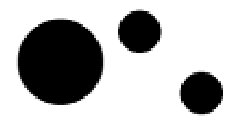

In [407]:
plt.figure(figsize=(11, 2))
tointerpolate = [torch.tensor(im_initial).double(),torch.tensor(im_final).double()]
cat_tointerp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in tointerpolate], dim=1)
plt.imshow(cat_tointerp**1.2, cmap='gray_r')
plt.axis('off')
plt.show()

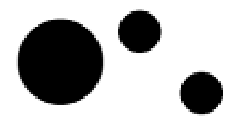

In [408]:
plt.figure(figsize=(11, 2))
tointerpolate_K = [poly_kernel(i.reshape(-1)).reshape(img_size,img_size)for i in tointerpolate]
cat_tointerp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in tointerpolate_K], dim=1)
plt.imshow(cat_tointerp**1.2, cmap='gray_r')
plt.axis('off')
plt.show()

### Compute Displacement Image Interpolation

In [409]:
interp = []
times = np.linspace(0, 1, 21)

for t in times:
    start = time()
    D = tointerpolate
    print(t)
    # for EMNIST
    #D = data.dataset.train_data[ix].view(-1, 28, 28).transpose(-1, -2).float()
    
    logit_q = torch.nn.Parameter(0*torch.rand(1, img_size*img_size))
    temp = torch.nn.Parameter(torch.tensor(0.1))

    optimizer = torch.optim.Adam([logit_q, temp], lr=0.03, amsgrad=True)
    
    for i in range(200):

        optimizer.zero_grad()
        
        q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(1, img_size, img_size)
        weights = [t,(1-t)] 

        loss = sum([weights[i]*gait.breg_sim_divergence(Kmat, q.reshape(-1),D[i].reshape(-1) ) for i in range(len(weights))]) #this is convex
#        loss = gait.breg_sim_entropy(img_kernel,q/2 +  weights[0]*D[0]*(1/2)+  weights[1]*D[1]*(1/2))  #this is convex
#        loss = gait.breg_sim_divergence(img_kernel,q,  weights[0]*D[0]*(1/2)+  weights[1]*D[1]*(1/2))  #this is convex
        if i % 50 == 0:
            print("t=%.1f - %d : %.3e" % (t, i, loss.item()))

        if False and i % 100 == 0:
            q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(img_size, img_size).data
            plt.figure(figsize=(1, 1))
            plt.imshow(q, cmap='gray_r');
            plt.show()

        loss.backward()
        optimizer.step()
    
    q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(img_size, img_size)
    interp.append(q.data/torch.max(q.data))
    
    print('Class time: ', time()-start)

0.0
t=0.0 - 0 : 1.432e+01
t=0.0 - 50 : 2.298e-02
t=0.0 - 100 : 3.300e-03
t=0.0 - 150 : 2.425e-03
Class time:  4.125560522079468
0.05
t=0.1 - 0 : 1.399e+01
t=0.1 - 50 : 4.136e-01
t=0.1 - 100 : 3.905e-01
t=0.1 - 150 : 3.896e-01
Class time:  4.068948745727539
0.1
t=0.1 - 0 : 1.365e+01
t=0.1 - 50 : 6.574e-01
t=0.1 - 100 : 6.285e-01
t=0.1 - 150 : 6.276e-01
Class time:  3.904205083847046
0.15000000000000002
t=0.2 - 0 : 1.332e+01
t=0.2 - 50 : 8.014e-01
t=0.2 - 100 : 7.726e-01
t=0.2 - 150 : 7.711e-01
Class time:  3.9291486740112305
0.2
t=0.2 - 0 : 1.299e+01
t=0.2 - 50 : 8.894e-01
t=0.2 - 100 : 8.650e-01
t=0.2 - 150 : 8.630e-01
Class time:  3.9283666610717773
0.25
t=0.2 - 0 : 1.266e+01
t=0.2 - 50 : 9.493e-01
t=0.2 - 100 : 9.305e-01
t=0.2 - 150 : 9.285e-01
Class time:  3.8811147212982178
0.30000000000000004
t=0.3 - 0 : 1.232e+01
t=0.3 - 50 : 9.957e-01
t=0.3 - 100 : 9.822e-01
t=0.3 - 150 : 9.803e-01
Class time:  3.903756856918335
0.35000000000000003
t=0.4 - 0 : 1.199e+01
t=0.4 - 50 : 1.036e+00
t=

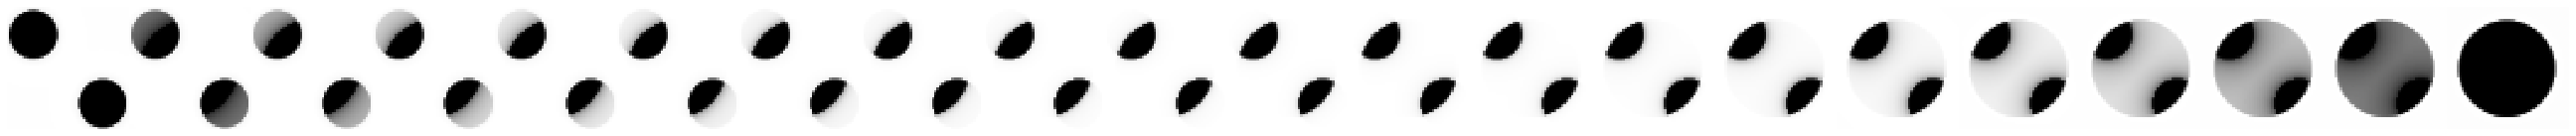

In [410]:
plt.figure(figsize=(1.1*len(interp)*2, 2.5))
cat_interp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in interp], dim=1)
plt.imshow(cat_interp**0.5, cmap='gray_r')
plt.axis('off')
#plt.savefig('mnist_gray_barys_breg', dpi=300)
plt.show()

--------------------
--------------------
##   Interpolate External Images

###  Exponential Family of  Kernels

In [348]:
img_size = 100

[Ygrid, Xgrid] = np.meshgrid(np.linspace(0, 1, img_size), np.linspace(0, 1, img_size))
Kmat = np.exp(-np.abs(Xgrid - Ygrid)**(2)/(5e-4))
Kmat = torch.tensor(Kmat)

img_kernel = lambda x: torch.matmul(torch.matmul(Kmat, x), Kmat)


###  Import 2 External Images

In [349]:
im_initial = imageio.imread("mario-1.png")
im_final = imageio.imread("mario-1-sh.png")

In [350]:
im_initial = np.abs(im_initial[:,:,0]) / np.abs(im_initial[:,:,0]).sum()
im_final = np.abs(im_final[:,:,0]) / np.abs(im_final[:,:,0]).sum()

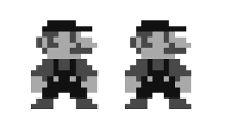

In [351]:
plt.figure(figsize=(11, 2))
tointerpolate = [torch.tensor(im_initial).double(),torch.tensor(im_final).double()]
cat_tointerp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in tointerpolate], dim=1)
plt.imshow(cat_tointerp**1.2, cmap='gray_r')
plt.axis('off')
plt.show()

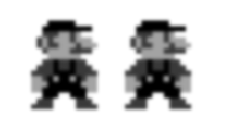

In [352]:
plt.figure(figsize=(11, 2))
tointerpolate_K = [img_kernel(i)for i in tointerpolate]
cat_tointerp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in tointerpolate_K], dim=1)
plt.imshow(cat_tointerp**1.2, cmap='gray_r')
plt.axis('off')
plt.show()

### Compute Displacement Image Interpolation

In [474]:
interp = []
times = np.linspace(0, 1, 21)

for t in times:
    start = time()
    D = tointerpolate
    print(t)
    # for EMNIST
    #D = data.dataset.train_data[ix].view(-1, 28, 28).transpose(-1, -2).float()
    
    logit_q = torch.nn.Parameter(0*torch.rand(1, img_size*img_size))
    temp = torch.nn.Parameter(torch.tensor(0.1))

    optimizer = torch.optim.Adam([logit_q, temp], lr=0.03, amsgrad=True)
    
    for i in range(500):

        optimizer.zero_grad()
        
        q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(1, img_size, img_size)
        weights = [t,(1-t)] 

        loss = sum([weights[i]*gait.breg_sim_divergence(img_kernel, q,D[i] ) for i in range(len(weights))]) #this is convex
#        loss = gait.breg_sim_entropy(img_kernel,q/2 +  weights[0]*D[0]*(1/2)+  weights[1]*D[1]*(1/2))  #this is convex
#        loss = gait.breg_sim_divergence(img_kernel,q,  weights[0]*D[0]*(1/2)+  weights[1]*D[1]*(1/2))  #this is convex
        if i % 100 == 0:
            print("t=%.1f - %d : %.3e" % (t, i, loss.item()))

        if False and i % 100 == 0:
            q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(img_size, img_size).data
            plt.figure(figsize=(1, 1))
            plt.imshow(q, cmap='gray_r');
            plt.show()

        loss.backward()
        optimizer.step()
    
    q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(img_size, img_size)
    interp.append(q.data/torch.max(q.data))
    
    print('Class time: ', time()-start)

0.0
t=0.0 - 0 : 1.702e+01
t=0.0 - 100 : 6.385e-03
t=0.0 - 200 : 2.894e-03
t=0.0 - 300 : 1.677e-03
t=0.0 - 400 : 1.106e-03
Class time:  1.7678556442260742
0.05
t=0.1 - 0 : 1.692e+01
t=0.1 - 100 : 1.750e-01
t=0.1 - 200 : 1.718e-01
t=0.1 - 300 : 1.706e-01
t=0.1 - 400 : 1.701e-01
Class time:  1.7064697742462158
0.1
t=0.1 - 0 : 1.683e+01
t=0.1 - 100 : 2.647e-01
t=0.1 - 200 : 2.620e-01
t=0.1 - 300 : 2.610e-01
t=0.1 - 400 : 2.605e-01
Class time:  1.7568459510803223
0.15000000000000002
t=0.2 - 0 : 1.674e+01
t=0.2 - 100 : 3.156e-01
t=0.2 - 200 : 3.134e-01
t=0.2 - 300 : 3.126e-01
t=0.2 - 400 : 3.122e-01
Class time:  1.8629865646362305
0.2
t=0.2 - 0 : 1.664e+01
t=0.2 - 100 : 3.468e-01
t=0.2 - 200 : 3.449e-01
t=0.2 - 300 : 3.443e-01
t=0.2 - 400 : 3.439e-01
Class time:  1.6760063171386719
0.25
t=0.2 - 0 : 1.655e+01
t=0.2 - 100 : 3.670e-01
t=0.2 - 200 : 3.653e-01
t=0.2 - 300 : 3.647e-01
t=0.2 - 400 : 3.643e-01
Class time:  1.6576097011566162
0.30000000000000004
t=0.3 - 0 : 1.645e+01
t=0.3 - 100 : 3.

### Show computed Interpolation


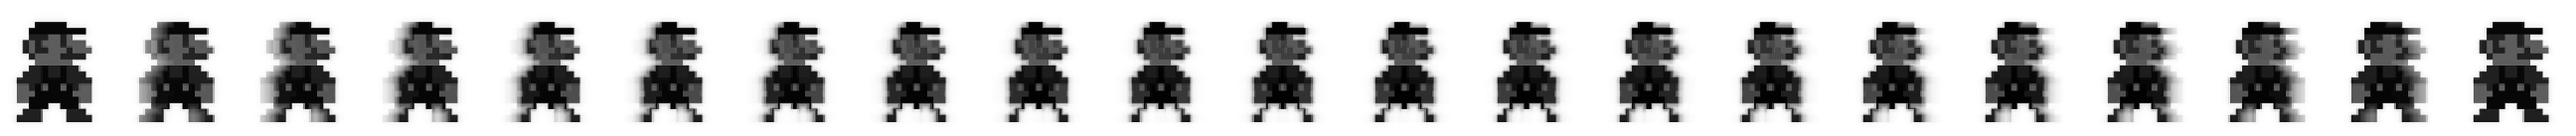

In [475]:
plt.figure(figsize=(1.1*len(interp)*2, 2.5))
cat_interp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in interp], dim=1)
plt.imshow(cat_interp**0.5, cmap='gray_r')
plt.axis('off')
#plt.savefig('mnist_gray_barys_breg', dpi=300)
plt.show()

------
###  Import 4 External Images

In [353]:
im_00 = imageio.imread("circles.png")
im_10 = imageio.imread("circle.png")
im_01 = imageio.imread("star_5.png")
im_11 = imageio.imread("star_4.png")

corners = []
for image in [im_00,im_10,im_01,im_11]:
    corners.append(torch.tensor(np.abs(image[:,:,0]) / np.abs(image[:,:,0]).sum()).double())

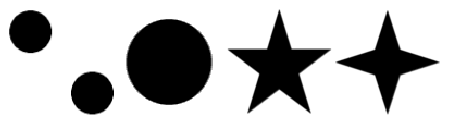

In [354]:
plt.figure(figsize=(11, 2))
cat_tointerp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in corners], dim=1)
plt.imshow(cat_tointerp**1.2, cmap='gray_r')
plt.axis('off')
plt.show()

### Compute Bilinear Image Interpolation

In [355]:
interp = []
times = [0,0.05,0.5,0.95,1]
simes = [0,0.05,0.5,0.95,1]

for s in simes: # Can be parallelized
    interp_row = []
    for t in times:
        start = time()
        p = corners
        print(t)
        print(s)
        # for EMNIST
        #D = data.dataset.train_data[ix].view(-1, 28, 28).transpose(-1, -2).float()

        logit_q = torch.nn.Parameter(0*torch.rand(1, img_size*img_size))
        temp = torch.nn.Parameter(torch.tensor(0.1))

        optimizer = torch.optim.Adam([logit_q, temp], lr=0.03, amsgrad=True)

        for i in range(500):

            optimizer.zero_grad()

            q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(1, img_size, img_size)
            
            weights = [t*s,t*(1-s),(1-t)*s,(1-t)*(1-s)] 

            loss = sum([weights[i]*gait.breg_sim_divergence(img_kernel, q, p[i]) for i in range(len(weights))]) #this is convex

            if i % 100 == 0:
                print("t=%.1f - %d : %.3e" % (t, i, loss.item()))

            if False and i % 100 == 0:
                q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(img_size, img_size).data
                plt.figure(figsize=(1, 1))
                plt.imshow(q, cmap='gray_r');
                plt.show()

            loss.backward()
            optimizer.step()

        q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(img_size, img_size)
        interp_row.append(q.data/torch.max(q.data))

        print('Class time: ', time()-start)
    interp.append(interp_row)

0
0
t=0.0 - 0 : nan
t=0.0 - 100 : 4.195e-02
t=0.0 - 200 : 1.176e-02
t=0.0 - 300 : 5.971e-03
t=0.0 - 400 : 3.714e-03
Class time:  5.1982200145721436
0.05
0
t=0.1 - 0 : nan
t=0.1 - 100 : 8.084e-02
t=0.1 - 200 : 5.342e-02
t=0.1 - 300 : 4.809e-02
t=0.1 - 400 : 4.600e-02
Class time:  6.128227472305298
0.5
0
t=0.5 - 0 : nan
t=0.5 - 100 : 3.526e-01
t=0.5 - 200 : 3.427e-01
t=0.5 - 300 : 3.401e-01
t=0.5 - 400 : 3.389e-01
Class time:  5.810866117477417
0.95
0
t=0.9 - 0 : nan
t=0.9 - 100 : nan
t=0.9 - 200 : nan
t=0.9 - 300 : 2.659e-01
t=0.9 - 400 : 2.652e-01
Class time:  5.6628992557525635
1
0
t=1.0 - 0 : nan
t=1.0 - 100 : nan
t=1.0 - 200 : nan
t=1.0 - 300 : nan
t=1.0 - 400 : 1.251e-03
Class time:  5.430723667144775
0
0.05
t=0.0 - 0 : nan
t=0.0 - 100 : 9.620e-02
t=0.0 - 200 : 6.877e-02
t=0.0 - 300 : 6.337e-02
t=0.0 - 400 : 6.123e-02
Class time:  5.668493032455444
0.05
0.05
t=0.1 - 0 : nan
t=0.1 - 100 : 2.138e-01
t=0.1 - 200 : 1.887e-01
t=0.1 - 300 : 1.836e-01
t=0.1 - 400 : 1.817e-01
Class time:  

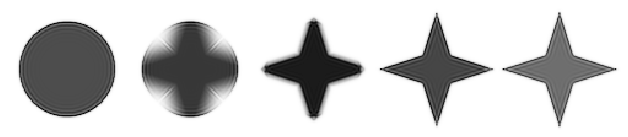

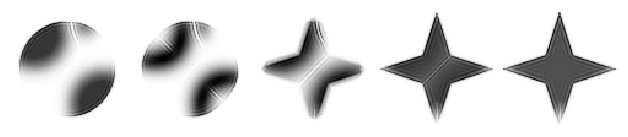

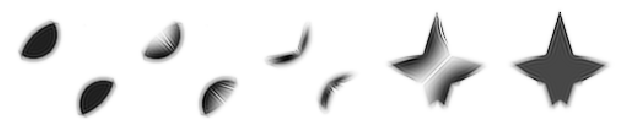

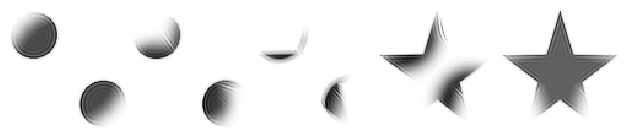

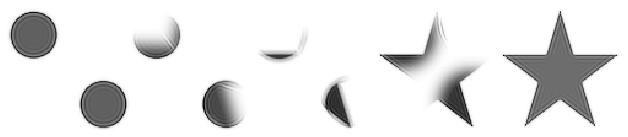

In [356]:
plt.figure(figsize=(1.1*len(interp*2), 2.5))
cat_interp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in interp[0][::-1]], dim=1)
plt.imshow(cat_interp**1, cmap='gray_r')
plt.axis('off')
plt.savefig('bilinear_1', dpi=300)
plt.show()
plt.figure(figsize=(1.1*len(interp*2), 2.5))
cat_interp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in interp[1][::-1]], dim=1)
plt.imshow(cat_interp**1, cmap='gray_r')
plt.axis('off')
plt.savefig('bilinear_2', dpi=300)
plt.show()
plt.figure(figsize=(1.1*len(interp*2), 2.5))
cat_interp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in interp[2][::-1]], dim=1)
plt.imshow(cat_interp**1, cmap='gray_r')
plt.axis('off')
plt.savefig('bilinear_3', dpi=300)
plt.show()
plt.figure(figsize=(1.1*len(interp*2), 2.5))
cat_interp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in interp[3][::-1]], dim=1)
plt.imshow(cat_interp**1, cmap='gray_r')
plt.axis('off')
plt.savefig('bilinear_4', dpi=300)
plt.show()
plt.figure(figsize=(1.1*len(interp*2), 2.5))
cat_interp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in interp[4][::-1]], dim=1)
plt.imshow(cat_interp**1, cmap='gray_r')
plt.axis('off')
plt.savefig('bilinear_5', dpi=300)
plt.show()

--------------------
--------------------
##   Interpolate Standard KL-Divergence

###  Identity Kernel

In [232]:
img_size = 100

Kmat = np.identity(img_size)
Kmat = torch.tensor(Kmat)

id_kernel = lambda x: torch.matmul(torch.matmul(Kmat, x), Kmat)


###  Import 2 External Images

In [256]:
im_initial = imageio.imread("circles.png")
im_final = imageio.imread("circle.png")

In [257]:
im_initial = np.abs(im_initial[:,:,0]) / np.abs(im_initial[:,:,0]).sum()
im_final = np.abs(im_final[:,:,0]) / np.abs(im_final[:,:,0]).sum()

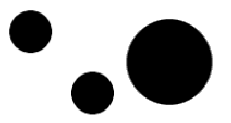

In [258]:
plt.figure(figsize=(11, 2))
tointerpolate = [torch.tensor(im_initial).double(),torch.tensor(im_final).double()]
cat_tointerp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in tointerpolate], dim=1)
plt.imshow(cat_tointerp**1.2, cmap='gray_r')
plt.axis('off')
plt.show()

### Compute Displacement Image Interpolation

In [259]:
interp = []
times = np.linspace(0, 1, 21)

for t in times:
    start = time()
    D = tointerpolate
    print(t)
    # for EMNIST
    #D = data.dataset.train_data[ix].view(-1, 28, 28).transpose(-1, -2).float()
    
    logit_q = torch.nn.Parameter(0*torch.rand(1, img_size*img_size))
    temp = torch.nn.Parameter(torch.tensor(0.1))

    optimizer = torch.optim.Adam([logit_q, temp], lr=0.03, amsgrad=True)
    
    for i in range(500):

        optimizer.zero_grad()
        
        q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(1, img_size, img_size)
        weights = [t,(1-t)] 

        loss = sum([weights[i]* nn.KLDivLoss()(q,  D[i]) for i in range(len(weights))]) #this is convex
 
        if i % 100 == 0:
            print("t=%.1f - %d : %.3e" % (t, i, loss.item()))

        if False and i % 100 == 0:
            q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(img_size, img_size).data
            plt.figure(figsize=(1, 1))
            plt.imshow(q, cmap='gray_r');
            plt.show()

        loss.backward()
        optimizer.step()
    
    q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(img_size, img_size)
    interp.append(q.data)
    
    print('Class time: ', time()-start)

0.0
t=0.0 - 0 : -9.210e-04


/home/mrkeithypatarroyo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1958: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


t=0.0 - 100 : -9.210e-04
t=0.0 - 200 : -9.210e-04
t=0.0 - 300 : -9.210e-04
t=0.0 - 400 : -9.210e-04
Class time:  0.9187846183776855
0.05
t=0.1 - 0 : -9.210e-04
t=0.1 - 100 : -9.210e-04
t=0.1 - 200 : -9.210e-04
t=0.1 - 300 : -9.210e-04
t=0.1 - 400 : -9.210e-04
Class time:  0.8938040733337402
0.1
t=0.1 - 0 : -9.210e-04
t=0.1 - 100 : -9.210e-04
t=0.1 - 200 : -9.210e-04
t=0.1 - 300 : -9.210e-04
t=0.1 - 400 : -9.210e-04
Class time:  0.9788587093353271
0.15000000000000002
t=0.2 - 0 : -9.210e-04
t=0.2 - 100 : -9.210e-04
t=0.2 - 200 : -9.210e-04
t=0.2 - 300 : -9.210e-04
t=0.2 - 400 : -9.210e-04
Class time:  0.9775485992431641
0.2
t=0.2 - 0 : -9.210e-04
t=0.2 - 100 : -9.210e-04
t=0.2 - 200 : -9.210e-04
t=0.2 - 300 : -9.210e-04
t=0.2 - 400 : -9.210e-04
Class time:  0.8689775466918945
0.25
t=0.2 - 0 : -9.210e-04
t=0.2 - 100 : -9.210e-04
t=0.2 - 200 : -9.210e-04
t=0.2 - 300 : -9.210e-04
t=0.2 - 400 : -9.210e-04
Class time:  1.0344362258911133
0.30000000000000004
t=0.3 - 0 : -9.210e-04
t=0.3 - 100 

### Show computed Interpolation


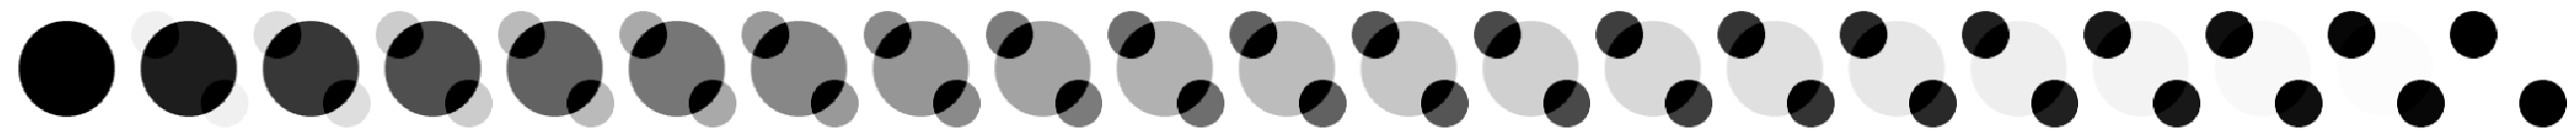

In [260]:
plt.figure(figsize=(1.1*len(interp)*2, 2.5))
cat_interp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in interp], dim=1)
plt.imshow(cat_interp**1.2, cmap='gray_r')
plt.axis('off')
#plt.savefig('mnist_gray_barys_breg', dpi=300)
plt.show()

------
###  Import 4 External Images

In [251]:
im_00 = imageio.imread("circles.png")
im_10 = imageio.imread("circle.png")
im_01 = imageio.imread("star_5.png")
im_11 = imageio.imread("star_4.png")

corners = []
for image in [im_00,im_10,im_01,im_11]:
    corners.append(torch.tensor(np.abs(image[:,:,0]) / np.abs(image[:,:,0]).sum()).double())

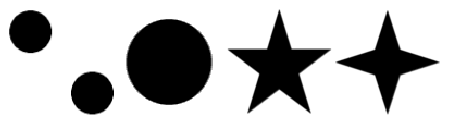

In [252]:
plt.figure(figsize=(11, 2))
cat_tointerp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in corners], dim=1)
plt.imshow(cat_tointerp**1.2, cmap='gray_r')
plt.axis('off')
plt.show()

### Compute Bilinear Image Interpolation


In [254]:
interp = []
times = [0,0.05,0.5,0.95,1]
simes = [0,0.05,0.5,0.95,1]

for s in simes: # Can be parallelized
    interp_row = []
    for t in times:
        start = time()
        p = corners
        print(t)
        print(s)
        # for EMNIST
        #D = data.dataset.train_data[ix].view(-1, 28, 28).transpose(-1, -2).float()

        logit_q = torch.nn.Parameter(0*torch.rand(1, img_size*img_size))
        temp = torch.nn.Parameter(torch.tensor(0.1))

        optimizer = torch.optim.Adam([logit_q, temp], lr=0.03, amsgrad=True)

        for i in range(500):

            optimizer.zero_grad()

            q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(1, img_size, img_size)
            
            weights = [t*s,t*(1-s),(1-t)*s,(1-t)*(1-s)] 

            loss = sum([weights[i]*nn.KLDivLoss()(q,  p[i]) for i in range(len(weights))]) #this is convex

            if i % 100 == 0:
                print("t=%.1f - %d : %.3e" % (t, i, loss.item()))

            if False and i % 100 == 0:
                q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(img_size, img_size).data
                plt.figure(figsize=(1, 1))
                plt.imshow(q, cmap='gray_r');
                plt.show()

            loss.backward()
            optimizer.step()

        q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(img_size, img_size)
        interp_row.append(q.data)

        print('Class time: ', time()-start)
    interp.append(interp_row)

0
0
t=0.0 - 0 : -7.786e-04


/home/mrkeithypatarroyo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1958: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


t=0.0 - 100 : -7.786e-04
t=0.0 - 200 : -7.786e-04
t=0.0 - 300 : -7.786e-04
t=0.0 - 400 : -7.786e-04
Class time:  1.7071049213409424
0.05
0
t=0.1 - 0 : -7.822e-04
t=0.1 - 100 : -7.822e-04
t=0.1 - 200 : -7.822e-04
t=0.1 - 300 : -7.822e-04
t=0.1 - 400 : -7.822e-04
Class time:  1.580519676208496
0.5
0
t=0.5 - 0 : -8.149e-04
t=0.5 - 100 : -8.149e-04
t=0.5 - 200 : -8.149e-04
t=0.5 - 300 : -8.149e-04
t=0.5 - 400 : -8.149e-04
Class time:  1.6982529163360596
0.95
0
t=0.9 - 0 : -8.476e-04
t=0.9 - 100 : -8.476e-04
t=0.9 - 200 : -8.476e-04
t=0.9 - 300 : -8.476e-04
t=0.9 - 400 : -8.476e-04
Class time:  1.7899858951568604
1
0
t=1.0 - 0 : -8.512e-04
t=1.0 - 100 : -8.512e-04
t=1.0 - 200 : -8.512e-04
t=1.0 - 300 : -8.512e-04
t=1.0 - 400 : -8.512e-04
Class time:  1.722705602645874
0
0.05
t=0.0 - 0 : -7.800e-04
t=0.0 - 100 : -7.800e-04
t=0.0 - 200 : -7.800e-04
t=0.0 - 300 : -7.800e-04
t=0.0 - 400 : -7.800e-04
Class time:  1.7978413105010986
0.05
0.05
t=0.1 - 0 : -7.834e-04
t=0.1 - 100 : -7.834e-04
t=0.1 

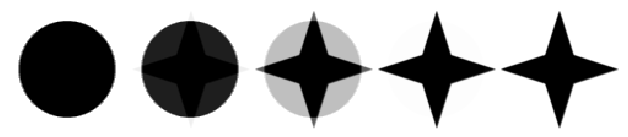

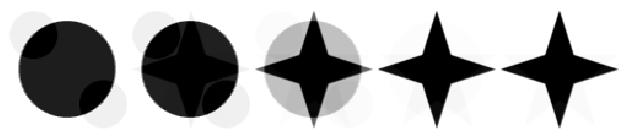

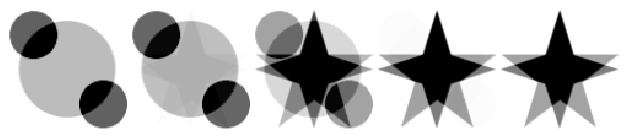

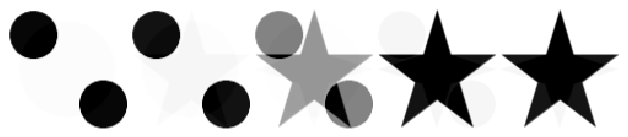

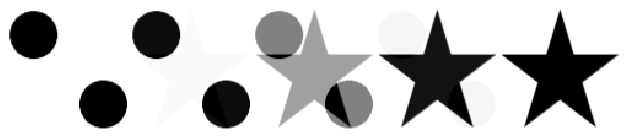

In [255]:
plt.figure(figsize=(1.1*len(interp*2), 2.5))
cat_interp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in interp[0][::-1]], dim=1)
plt.imshow(cat_interp**1.2, cmap='gray_r')
plt.axis('off')
#plt.savefig('mnist_gray_barys_breg', dpi=300)
plt.show()
plt.figure(figsize=(1.1*len(interp*2), 2.5))
cat_interp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in interp[1][::-1]], dim=1)
plt.imshow(cat_interp**1.2, cmap='gray_r')
plt.axis('off')
#plt.savefig('mnist_gray_barys_breg', dpi=300)
plt.show()
plt.figure(figsize=(1.1*len(interp*2), 2.5))
cat_interp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in interp[2][::-1]], dim=1)
plt.imshow(cat_interp**1.2, cmap='gray_r')
plt.axis('off')
#plt.savefig('mnist_gray_barys_breg', dpi=300)
plt.show()
plt.figure(figsize=(1.1*len(interp*2), 2.5))
cat_interp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in interp[3][::-1]], dim=1)
plt.imshow(cat_interp**1.2, cmap='gray_r')
plt.axis('off')
#plt.savefig('mnist_gray_barys_breg', dpi=300)
plt.show()
plt.figure(figsize=(1.1*len(interp*2), 2.5))
cat_interp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in interp[4][::-1]], dim=1)
plt.imshow(cat_interp**1.2, cmap='gray_r')
plt.axis('off')
#plt.savefig('mnist_gray_barys_breg', dpi=300)
plt.show()

--------------------
--------------------
##   Other Optimizers for GAIT Divergence

###  Exponential Family of Kernels

In [36]:
img_size = 100

[Ygrid, Xgrid] = np.meshgrid(np.linspace(0, 1, img_size), np.linspace(0, 1, img_size))
Kmat = np.exp(-np.abs(Xgrid - Ygrid)**2/(5e-4))
Kmat = torch.tensor(Kmat)

img_kernel = lambda x: torch.matmul(torch.matmul(Kmat, x), Kmat)


###  Import 2 External Images

In [37]:
im_initial = imageio.imread("circles.png")
im_final = imageio.imread("circle.png")

In [38]:
im_initial = np.abs(im_initial[:,:,0]) / np.abs(im_initial[:,:,0]).sum()
im_final = np.abs(im_final[:,:,0]) / np.abs(im_final[:,:,0]).sum()

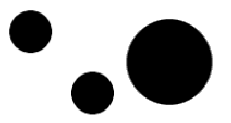

In [39]:
plt.figure(figsize=(11, 2))
tointerpolate = [torch.tensor(im_initial).double(),torch.tensor(im_final).double()]
cat_tointerp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in tointerpolate], dim=1)
plt.imshow(cat_tointerp**1.2, cmap='gray_r')
plt.axis('off')
plt.show()

### Compute Displacement Image Interpolation - LBFGS

In [41]:
interp = []
times = np.linspace(0, 1, 21)

for t in times:
    start = time()
    D = tointerpolate
    print(t)
    # for EMNIST
    #D = data.dataset.train_data[ix].view(-1, 28, 28).transpose(-1, -2).float()
    
    logit_q = torch.nn.Parameter(0*torch.rand(1, img_size*img_size))
    temp = torch.nn.Parameter(torch.tensor(0.1))

    optimizer = torch.optim.LBFGS([logit_q, temp], lr=0.8)
    
    for i in range(15):

        def closure():

            optimizer.zero_grad()
            q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(1, img_size, img_size)
            weights = [t,(1-t)] 
            loss = sum([weights[i]*gait.breg_sim_divergence(img_kernel,q,  D[i]) for i in range(len(weights))]) #this is convex
            print('loss:', loss.item())
            loss.backward()
            return loss
        optimizer.step(closure)
        
       
        if i % 5 == 0:
            print("t=%.1f - %d : %.3e" % (t, i, loss.item()))

    
    q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(img_size, img_size)
    interp.append(q.data)
    
    print('Class time: ', time()-start)

0.0
loss: 15.84450978787687
loss: 15.841320070090513
loss: 2.961885897287395
loss: 0.0459278193771615
loss: 0.033929019537991316
loss: 0.003926301769366076
loss: -0.002352481632678374
loss: -0.004051887762311031
loss: -0.004669624867186885
loss: -0.005158170629509728
loss: -0.005532073819688375
loss: -0.005721046108156877
loss: -0.005823825993781496
loss: -0.005889022020987338
loss: -0.005954210687481815
loss: -0.005993431898672243
loss: -0.006032457882585367
loss: -0.00606067685997721
loss: -0.0060847148793862675
loss: -0.006113479565384642
t=0.0 - 0 : -4.758e-02
loss: -0.006138381980988031
loss: -0.006154649158262405
loss: -0.006166191951682202
loss: -0.006180525832672971
loss: -0.006194650427786762
loss: -0.006203628524814594
loss: -0.006213100139836037
loss: -0.006220207170311692
loss: -0.006228045402165416
loss: -0.006234753580248308
loss: -0.006238919087131743
loss: -0.0062440308106738686
loss: -0.006248576575632116
loss: -0.006253273903978578
loss: -0.006256285434198389
loss: -0

### Show computed Interpolation


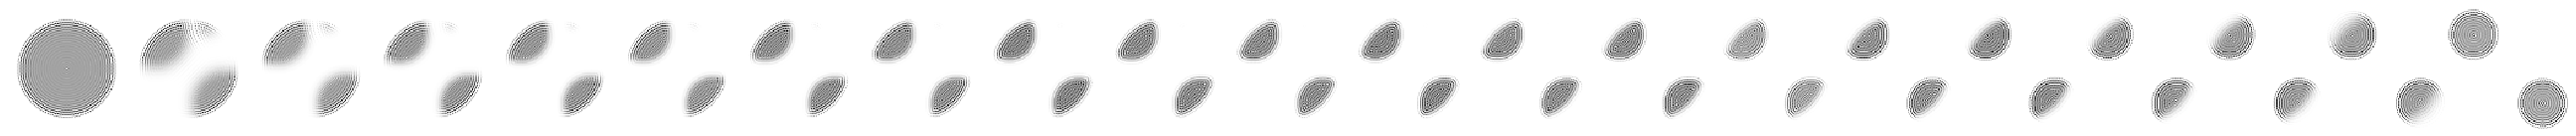

In [42]:
plt.figure(figsize=(1.1*len(interp)*2, 2.5))
cat_interp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in interp], dim=1)
plt.imshow(cat_interp**1.2, cmap='gray_r')
plt.axis('off')
#plt.savefig('mnist_gray_barys_breg', dpi=300)
plt.show()

--------------------
--------------------
##   Current Problems with GAIT Divergence

## 1. Not transporting the distribution( rather growing like a tree)

## 2. Numerical precision(maybe)


###   Exponential Family of Kernels

In [22]:
img_size = 100

[Ygrid, Xgrid] = np.meshgrid(np.linspace(0, 1, img_size), np.linspace(0, 1, img_size))
Kmat = np.exp(-np.abs(Xgrid - Ygrid)**2/(5e-3))
Kmat = torch.tensor(Kmat)

img_kernel = lambda x: torch.matmul(torch.matmul(Kmat, x), Kmat)


###  Import 2 External Images

In [23]:
im_initial = imageio.imread("circle_r.png")
im_final = imageio.imread("circle_l.png")

In [24]:
im_initial = np.abs(im_initial[:,:,0]) / np.abs(im_initial[:,:,0]).sum()
im_final = np.abs(im_final[:,:,0]) / np.abs(im_final[:,:,0]).sum()

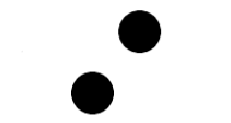

In [25]:
plt.figure(figsize=(11, 2))
tointerpolate = [torch.tensor(im_initial).double(),torch.tensor(im_final).double()]
cat_tointerp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in tointerpolate], dim=1)
plt.imshow(cat_tointerp**1.2, cmap='gray_r')
plt.axis('off')
plt.show()

### Compute Displacement Image Interpolation

In [26]:
interp = []
times = np.linspace(0, 1, 21)

for t in times:
    start = time()
    D = tointerpolate
    print(t)
    # for EMNIST
    #D = data.dataset.train_data[ix].view(-1, 28, 28).transpose(-1, -2).float()
    
    logit_q = torch.nn.Parameter(0*torch.rand(1, img_size*img_size))
    temp = torch.nn.Parameter(torch.tensor(0.1))

    optimizer = torch.optim.Adam([logit_q, temp], lr=0.03, amsgrad=True)
    
    for i in range(500):

        optimizer.zero_grad()
        
        q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(1, img_size, img_size)
        weights = [t,(1-t)] 

        loss = sum([weights[i]*gait.breg_sim_divergence(img_kernel,q,  D[i]) for i in range(len(weights))]) #this is convex
 
        if i % 100 == 0:
            print("t=%.1f - %d : %.3e" % (t, i, loss.item()))

        if False and i % 100 == 0:
            q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(img_size, img_size).data
            plt.figure(figsize=(1, 1))
            plt.imshow(q, cmap='gray_r');
            plt.show()

        loss.backward()
        optimizer.step()
    
    q = torch.softmax(logit_q /  torch.exp(temp), dim=1).view(img_size, img_size)
    interp.append(q.data/torch.max(q.data))
    
    print('Class time: ', time()-start)

0.0
t=0.0 - 0 : 2.942e+01
t=0.0 - 100 : -3.617e-02
t=0.0 - 200 : -4.273e-02
t=0.0 - 300 : -4.488e-02
t=0.0 - 400 : -4.595e-02
Class time:  1.7452874183654785
0.05
t=0.1 - 0 : 2.858e+01
t=0.1 - 100 : 7.651e-01
t=0.1 - 200 : 7.579e-01
t=0.1 - 300 : 7.554e-01
t=0.1 - 400 : 7.541e-01
Class time:  1.664686918258667
0.1
t=0.1 - 0 : 2.774e+01
t=0.1 - 100 : 1.438e+00
t=0.1 - 200 : 1.431e+00
t=0.1 - 300 : 1.428e+00
t=0.1 - 400 : 1.427e+00
Class time:  1.8106410503387451
0.15000000000000002
t=0.2 - 0 : 2.690e+01
t=0.2 - 100 : 2.020e+00
t=0.2 - 200 : 2.012e+00
t=0.2 - 300 : 2.010e+00
t=0.2 - 400 : 2.009e+00
Class time:  1.8286843299865723
0.2
t=0.2 - 0 : 2.606e+01
t=0.2 - 100 : 2.536e+00
t=0.2 - 200 : 2.530e+00
t=0.2 - 300 : 2.528e+00
t=0.2 - 400 : 2.527e+00
Class time:  1.8362855911254883
0.25
t=0.2 - 0 : 2.522e+01
t=0.2 - 100 : 3.006e+00
t=0.2 - 200 : 3.000e+00
t=0.2 - 300 : 2.999e+00
t=0.2 - 400 : 2.998e+00
Class time:  1.6626737117767334
0.30000000000000004
t=0.3 - 0 : 2.438e+01
t=0.3 - 100 :

### Show computed Interpolation


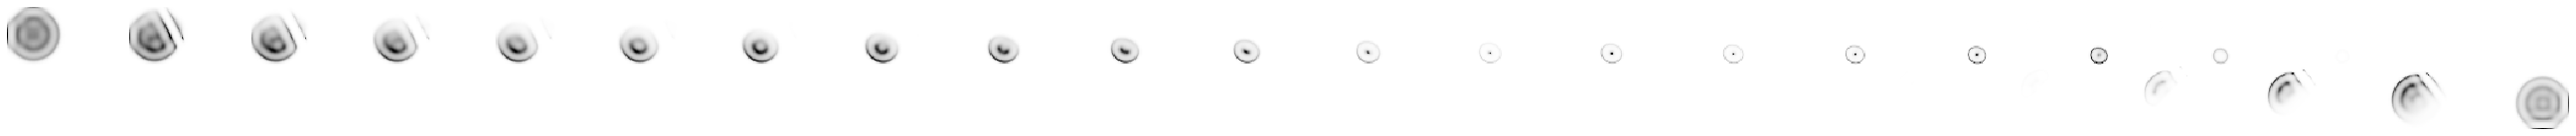

In [27]:
plt.figure(figsize=(1.1*len(interp)*2, 2.5))
cat_interp = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in interp], dim=1)
plt.imshow(cat_interp**1.2, cmap='gray_r')
plt.axis('off')
#plt.savefig('mnist_gray_barys_breg', dpi=300)
plt.show()